In [27]:
import argparse
import bnlearn as bn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


from dgl import DGLGraph
from modules import GAT_RNF

from torch_geometric.explain import AttentionExplainer, ModelConfig, ExplainerConfig, Explainer, GNNExplainer

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [28]:
def undirected_SHD(g1, g2):
    g1 = np.tril(((g1 + g1.T) > 0).astype(int))
    g2 = np.tril(((g2 + g2.T) > 0).astype(int))
    return np.sum(np.abs(g1-g2))

def comb_SHD(g1, g2):
    return np.sum(np.abs(g1 - g2)), undirected_SHD(g1,g2)

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
DATASET_NAME="insurance"
NUM_SAMPLES=10000
RNF_DIM=50
RNF_INTERMEDIATE_DIM=25
RNF_INIT_METHOD="xavier_uniform"
NUM_HEADS=3
NUM_EPOCHS=50
LEARNING_RATE=0.001
BATCH_SIZE=64
EXPERIMENT_ID="asia_v1"
NUM_EPOCHS=50

In [31]:
#### Defining the paths ####
dataset_path = f"BIFs/{DATASET_NAME}.bif"

save_dir = f"results/{EXPERIMENT_ID}"
#### Building the dataset ####
causal_model = bn.import_DAG(dataset_path)
df_samples = bn.sampling(causal_model, n=NUM_SAMPLES)
nodes_orig = list(causal_model['adjmat'].columns)
num_nodes = len(nodes_orig)

target_symmetric_adj = (causal_model['adjmat'] + causal_model['adjmat'].T).to_numpy()

node_features = torch.from_numpy(df_samples.to_numpy() - 0.5).type(torch.float32).unsqueeze(2)

#### Defining functionality ####
def build_graph(features, num_nodes, src_nodes, dst_nodes):
    g = DGLGraph()
    g.add_nodes(num_nodes)
    g.ndata['features'] = features
    g.add_edges(src_nodes, dst_nodes)
    return g

def collate_fn(data):
    return data
    
#### Preparing for training ####
initial_adj = torch.ones((num_nodes, num_nodes)) - torch.eye(num_nodes)
src_nodes, dst_nodes = torch.nonzero(initial_adj).T

graph_dataset = [build_graph(features, num_nodes, src_nodes, dst_nodes) for features in node_features]

loader = DataLoader(graph_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

#### Main Operations
model = GAT_RNF(num_nodes=len(nodes_orig), rnf_dim=RNF_DIM, rnf_intermediate_dim=RNF_INTERMEDIATE_DIM, rnf_init_method=RNF_INIT_METHOD, num_heads=NUM_HEADS)

optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

loss_fn = nn.MSELoss()

[bnlearn] >Import <BIFs/insurance.bif>
[bnlearn] >Loading bif file <BIFs/insurance.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Accident] does not add up to 1 but is: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[bnlearn] >CPD [CarValue] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >CPD [DrivHist] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [DrivingSkill] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [HomeBase] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [MedCost] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn]

In [32]:
def train_epoch(loader, model, optimizer, loss_fn):
    for g_list in loader:
        optimizer.zero_grad()
        target_ls, pred_ls = [], []
        for g in g_list:
            target_ls.append(g.ndata['features'])
            out = model(g, g.ndata['features'])
            pred_ls.append(out)
        loss = loss_fn(torch.stack(tuple(out)), torch.stack(tuple(target_ls)))
        loss.backward()
        optimizer.step()


In [33]:
for epoch_id in range(1,NUM_EPOCHS+1):
    print(f'Epoch {epoch_id}')
    train_epoch(loader, model, optimizer, loss_fn)
torch.save(model.state_dict(), "saved_model/gat_rnf_insurance.pt")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


In [7]:
model.load_state_dict(torch.load("saved_model/gat_rnf_insurance.pt", weights_only=True))

<All keys matched successfully>

In [8]:
atts_l = []
for g_list in loader:
    optimizer.zero_grad()
    target_ls, pred_ls = [], []
    for g in g_list:
        target_ls.append(g.ndata['features'])
        out = model(g, g.ndata['features'], get_attention=True)
        pred_ls.append(out[0])
        atts_l.append(out[1].detach().numpy())
    loss = loss_fn(torch.stack(tuple(out[0])), torch.stack(tuple(target_ls)))
    loss.backward()
    optimizer.step()

In [9]:
atts = np.array(atts_l).reshape(NUM_SAMPLES, -1)
atts = np.mean(atts, axis=0).reshape(-1)

In [10]:
num_nodes = len(nodes_orig)

In [11]:
initial_adj.shape

torch.Size([27, 27])

In [12]:
atts.shape

(702,)

In [13]:
np.max(atts)

0.21176305

In [14]:
new_adj = np.zeros_like(initial_adj)
edges_list = np.where(initial_adj>0)
thresh = np.max(atts) - 1.5 * np.std(atts)
print(thresh)
for i in range(len(np.where(initial_adj>0)[0])):
    e_i = (edges_list[0][i], edges_list[1][i])
    # new_adj[e_i[0]][e_i[1]] = atts[i]
    if atts[i] > thresh:
        new_adj[e_i[0]][e_i[1]] = 1

0.14112848788499832


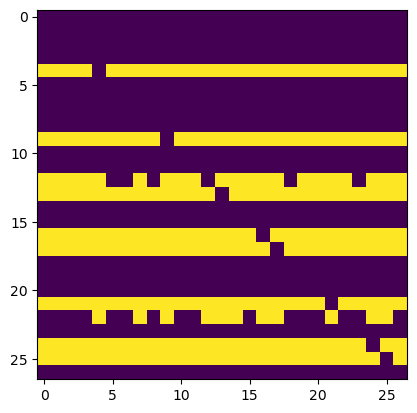

In [15]:
plt.imshow(new_adj)

In [16]:
g = nx.DiGraph(new_adj, nodes=nodes_orig)

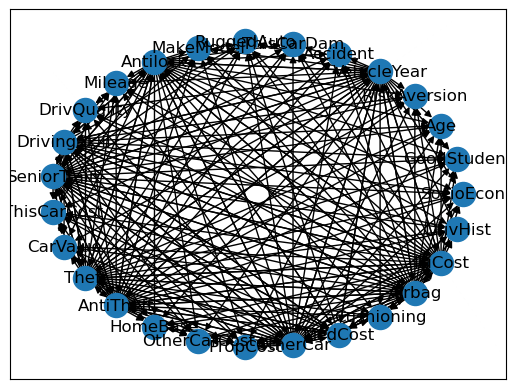

In [17]:
pos = nx.circular_layout(g)
nx.draw_networkx(g, pos, labels = {
    i:nodes_orig[i] for i in range(len(g.nodes))
})

In [18]:
adj = nx.adjacency_matrix(g)
comb_SHD(adj.toarray(), causal_model['adjmat'].astype(int).to_numpy())

(270.0, 199)

In [19]:
new_thresh_adj = np.zeros_like(new_adj)
for i in range(len(new_adj)):
    for j in range(len(new_adj[i])):
        if new_adj[i][j] >= np.mean(new_adj[i]) + 0.35 * np.std(new_adj[i]):
            new_thresh_adj[i][j] = 1

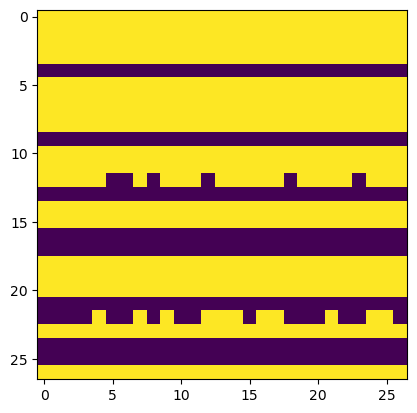

In [20]:
plt.imshow(new_thresh_adj)

In [24]:
new_adj = np.zeros_like(initial_adj)
edges_list = np.where(initial_adj>0)
thresh = np.max(atts) - 1.5 * np.std(atts)
print(thresh)
for i in range(len(np.where(initial_adj>0)[0])):
    e_i = (edges_list[0][i], edges_list[1][i])
    new_adj[e_i[0]][e_i[1]] = atts[i]

0.14112848788499832


In [25]:
g = nx.DiGraph(new_thresh_adj, nodes=nodes_orig)

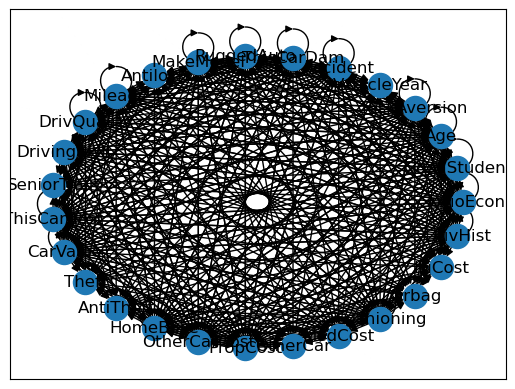

In [26]:
pos = nx.circular_layout(g)
nx.draw_networkx(g, pos, labels = {
    i:nodes_orig[i] for i in range(len(g.nodes))
})

In [127]:
adj = nx.adjacency_matrix(g)

In [128]:
comb_SHD(adj.toarray(), causal_model['adjmat'].astype(int).to_numpy())

(72.0, 70)